# Analysis of KOIN stock price
Michael Vandervelden, 2023 
<br>
<br>

Forecasting with linear regression and visualising stock performance from 2018 through 2022.

In [88]:
# Import necessary packages. 

import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

In [3]:
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

C:\Users\brand\AppData\Local\Temp\ipykernel_48300\3467016303.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Connecting to our MySQL database. I'll be running SQL queries through Python, and visualisation the resulting dataframes using the pandas and plotly libraries.

In [5]:


db = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    passwd = 'pwd',
    database = 'etfs'
)

In [8]:
# Function to execute SQL queries through Python

mycursor = db.cursor()

def sql(yourQuery):
    mycursor.execute(yourQuery)
    myresult = mycursor.fetchall()
    df = pd.DataFrame(myresult, columns = mycursor.column_names)
    return df

In [10]:
initial_koin_df = sql('''
    select * from koin order by `date`;
    ''')

In [11]:
initial_koin_df

,date,open,high,low,close,volume,dividends,stock splits
0,2018-01-29 21:00:00,23.59450,23.60396,23.38636,23.45732,46300.00000,0.00000,0.00000
1,2018-01-30 21:00:00,23.62288,23.63140,23.46205,23.59450,39700.00000,0.00000,0.00000
2,2018-01-31 21:00:00,23.52827,23.61342,23.31825,23.34852,24900.00000,0.00000,0.00000
3,2018-02-01 21:00:00,23.33906,23.33906,22.79982,22.82820,17100.00000,0.00000,0.00000
4,2018-02-04 21:00:00,22.72413,22.89442,22.04297,22.09028,23500.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...
1187,2022-10-16 21:00:00,29.76000,30.12000,29.45000,29.92900,7600.00000,0.00000,0.00000
1188,2022-10-17 21:00:00,30.53000,30.53000,30.21000,30.21000,900.00000,0.00000,0.00000
1189,2022-10-18 21:00:00,30.03000,30.03000,29.74500,29.74500,600.00000,0.00000,0.00000
1190,2022-10-19 21:00:00,30.24000,30.24000,29.73000,29.84900,800.00000,0.00000,0.00000


## Exploratory Data Analysis

Determining mean stock price at market close, by year from 2018 through 2022.

In [23]:

mean_high = sql('''
    with mean_high as (
    select year(`date`) as 'year', avg(high) as `mean high`
    from koin 
    group by year(`date`)
    ) 
    select year, `mean high`
    from mean_high
    order by year
''')

In [24]:
mean_low = sql('''
    with mean_low as (
    select year(`date`) as 'year', avg(low) as `mean low`
    from koin 
    group by year(`date`)
    ) 
    select year, `mean low`
    from mean_low
    order by year
''')

In [26]:
mean_close = sql('''
    with mean_close as (
    select year(`date`) as 'year', avg(close) as `mean close`
    from koin 
    group by year(`date`)
    ) 
    select year, `mean close`
    from mean_close
    order by year
''')

In [29]:
mean_close

,year,mean close
0,2018,23.395275474
1,2019,25.364084444
2,2020,30.095094150
3,2021,41.248200357
4,2022,36.146364532


In [31]:
mean_high

,year,mean high
0,2018,23.526699827
1,2019,25.438065793
2,2020,30.330903794
3,2021,41.467217301
4,2022,36.391305418


In [32]:
mean_low

,year,mean low
0,2018,23.281321465
1,2019,25.281956825
2,2020,29.885753754
3,2021,41.018137500
4,2022,35.916177339


In [36]:
# Drop dividends and stock splits columns

sql(
    '''
     alter table koin drop dividends;
     alter table koin drop `stock splits`;

    '''
)

""


Calculating the mean stock price over each day.

In [41]:
sql(

    '''
    select *, (open + high + low + close) / 4 as daily_mean
    from koin
    
    
    '''
)

,date,open,high,low,close,volume,daily_mean
0,2018-01-29 21:00:00,23.59450,23.60396,23.38636,23.45732,46300.00000,23.510535000
1,2018-01-30 21:00:00,23.62288,23.63140,23.46205,23.59450,39700.00000,23.577707500
2,2018-01-31 21:00:00,23.52827,23.61342,23.31825,23.34852,24900.00000,23.452115000
3,2018-02-01 21:00:00,23.33906,23.33906,22.79982,22.82820,17100.00000,23.076535000
4,2018-02-04 21:00:00,22.72413,22.89442,22.04297,22.09028,23500.00000,22.437950000
...,...,...,...,...,...,...,...
1187,2022-10-16 21:00:00,29.76000,30.12000,29.45000,29.92900,7600.00000,29.814750000
1188,2022-10-17 21:00:00,30.53000,30.53000,30.21000,30.21000,900.00000,30.370000000
1189,2022-10-18 21:00:00,30.03000,30.03000,29.74500,29.74500,600.00000,29.887500000
1190,2022-10-19 21:00:00,30.24000,30.24000,29.73000,29.84900,800.00000,30.014750000


Calculating the 5-day moving average for the stock price at market close. The resulting dataframe will be used again in our visualisations.

In [50]:


koin_w_moving_average = sql(

    '''
    select *, avg(close) over(order by `date` rows between 5 preceding and current row)
    as moving_average
    from koin
    
    '''
)

koin_w_moving_average

,date,open,high,low,close,volume,moving_average
0,2018-01-29 21:00:00,23.59450,23.60396,23.38636,23.45732,46300.00000,23.457320000
1,2018-01-30 21:00:00,23.62288,23.63140,23.46205,23.59450,39700.00000,23.525910000
2,2018-01-31 21:00:00,23.52827,23.61342,23.31825,23.34852,24900.00000,23.466780000
3,2018-02-01 21:00:00,23.33906,23.33906,22.79982,22.82820,17100.00000,23.307135000
4,2018-02-04 21:00:00,22.72413,22.89442,22.04297,22.09028,23500.00000,23.063764000
...,...,...,...,...,...,...,...
1187,2022-10-16 21:00:00,29.76000,30.12000,29.45000,29.92900,7600.00000,29.586166666
1188,2022-10-17 21:00:00,30.53000,30.53000,30.21000,30.21000,900.00000,29.659500000
1189,2022-10-18 21:00:00,30.03000,30.03000,29.74500,29.74500,600.00000,29.718666666
1190,2022-10-19 21:00:00,30.24000,30.24000,29.73000,29.84900,800.00000,29.781166666


## Visualisations
<br>

Includes line plots, bar graphs and interactive candlestick plots.

In [106]:
# Forecasting with linear regression / visualizations

# Price at market close over 2018 through 2022


figure = px.line(koin_w_moving_average, x=koin_w_moving_average.date,
                y=koin_w_moving_average.close,
                title="KOIN close price 2018-2022")


figure.show()

In [107]:
# Candlestick plot

figure2 = go.Figure(data=[go.Candlestick(x = koin_w_moving_average.date,
                                        open = koin_w_moving_average["open"],
                                        high = koin_w_moving_average["high"],
                                        low = koin_w_moving_average["low"],
                                        close = koin_w_moving_average["close"])])

figure2.update_layout(title= "KOIN open, high, low and close positions",
                    xaxis_rangeslider_visible = False)
figure2.show()

In [108]:
# Bar plot

figure3 = px.bar(koin_w_moving_average, x=koin_w_moving_average.date, y=koin_w_moving_average.close, title="KOIN value at market close")
figure3.show()

Plot of the 5-day moving average is below. Notice that it is extremely similar to, but much smoother than, the regular plot of the close price. This allows for a simplified presentation of trends in the stock's price.

In [109]:
figure5 = px.line(koin_w_moving_average, x=koin_w_moving_average.date, y=koin_w_moving_average.moving_average, title="KOIN close 5-day moving average 2018-2022")
figure5.show()

In [110]:
# Interactive candlestick plot 

figure4 = go.Figure(data=[go.Candlestick(x=koin_w_moving_average.date,
                                        open = koin_w_moving_average["open"],
                                        high = koin_w_moving_average["high"],
                                        low = koin_w_moving_average["low"],
                                        close = koin_w_moving_average["close"])])

figure4.update_layout(title="KOIN Stock Interactive Plot")

figure4.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
            
        ])))

figure4.show()


## Forecasting with linear regression
<br>


In [95]:
koin_w_moving_average['time'] = np.arange(len(koin_w_moving_average.index))


Add a timestep column to the dataframe. This allows the creation of a linear regression object, from which we can derive the slope and intercept for our plots. 

In [97]:
koin_w_moving_average.head()

,date,open,high,low,close,volume,moving_average,time
0,2018-01-29 21:00:00,23.59450,23.60396,23.38636,23.45732,46300.00000,23.457320000,0
1,2018-01-30 21:00:00,23.62288,23.63140,23.46205,23.59450,39700.00000,23.525910000,1
2,2018-01-31 21:00:00,23.52827,23.61342,23.31825,23.34852,24900.00000,23.466780000,2
3,2018-02-01 21:00:00,23.33906,23.33906,22.79982,22.82820,17100.00000,23.307135000,3
4,2018-02-04 21:00:00,22.72413,22.89442,22.04297,22.09028,23500.00000,23.063764000,4


In [96]:
res = stats.linregress(koin_w_moving_average['time'].astype(float), koin_w_moving_average['close'].astype(float))

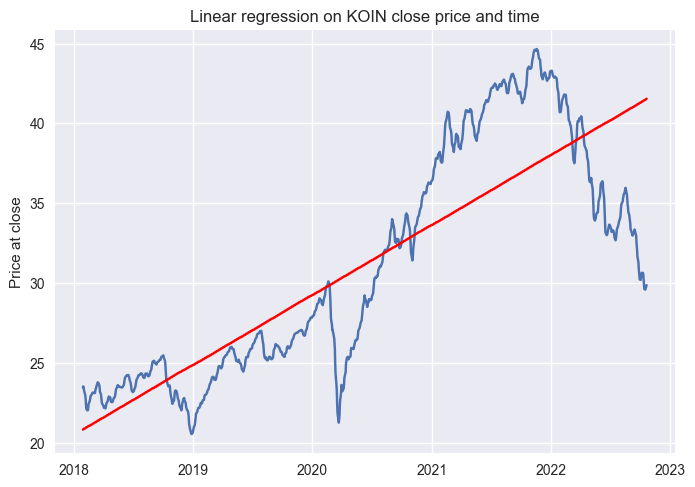

In [105]:
plt.plot(koin_w_moving_average['date'], koin_w_moving_average['moving_average'])
plt.plot(koin_w_moving_average['date'], res.intercept + res.slope*koin_w_moving_average['time'], 'r')
plt.title("Linear regression on KOIN close price and time")
plt.ylabel("Price at close")
plt.show()

Even considering the periodic downturns, the price can still be expected to rise, making the stock a wise investment for potential long-term gains. 